In [90]:
# Design specifications and material properties

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import solve_bvp
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar

# Fuel assembly (FA) representative of average core conditions
P_FA = 6.641 #[MW] Fuel assembly thermal power
N_FP = 284 #[pin] Number of fuel pins in the fuel assembly
q_l0 = 26.03 #[kW/m] Linear heat rate at fuel midplane, q'(0)
pitch = 13.6 #[mm] Pin pitch
T_co_in = 400 #[°C] Coolant inlet temperature
T_co_out = 480 #[°C] Coolant outlet temperature

# Coolant properties (uniform along the channel) - Liquid Pb
cp_co = 146 #[J/kg-°C] Average heat capacity
rho_co = 10520 #[kg/m^3] Average density
mu_co = 0.002 #[Pa-s] Average dynamic viscosity
k_co = 15.5 #[W/m-°C] Average thermal conductivity

# Fuel pins
D_clad_ext = 8.50 #[mm] External diameter of cladding
t_clad = 0.600 #[mm] Cladding thickness
H_act = 1100 #[mm] Active length
H_tot = 2100 #[mm] Total length

# Fuel - solid pellets (MOX)
TD_fuel = 11.31 #[g/cm^3] Theoretical density of MOX fuel
rho_fuel = 0.88*TD_fuel #[g/cm^3] Density of fuel
T_fuel_melt = 2730 #[°C] Melting temperature of fresh fuel
D_fuel = 6.98 #[mm] Fuel pellet diameter
alpha_l_fuel = 12e-6 #[°C^-1] Linear coefficient of thermal expansion (T_ref = 25°C)
Y_fuel = 170 #[GPa] Young's modulus of solid pellets
nu_poisson_fuel = 0.31 #[/] Poisson's coefficient

# Cladding - Ferritic-martensitic steel T91 (UNS No. K90901)
T_clad_melt = 1500 #[°C] Melting temperature of cladding
k_clad = 28.7 #[W/m-°C] Average thermal conductivity of cladding
alpha_l_clad = 12e-6 #[°C^-1] Linear coefficient of thermal expansion (T_ref = 25°C)
Y_clad = 170 #[GPa] Young's modulus of cladding
nu_poisson_clad = 0.3 #[/] Poisson's coefficient
#SY_clad = 563.1 - 4.878e-1*T_clad + 1.6e-3*T_clad**2 - 3e-6*T_clad**3 + 8e-10*T_clad**4 #[MPa] Yield strength of cladding

In [91]:
# COLD GEOMETRY ANALYSIS
# (I)

# Coolant mass flowrate  (square channel 1/4*4 fuel pins = 1 fuel pin)
P_FP = P_FA/N_FP #[MW/pin] Average thermal power per fuel pin
m_co = P_FP/(cp_co*(T_co_out - T_co_in))*1e6 #[kg/s] Average coolant mass flowrate per channel
volflow_co = m_co/rho_co #[m^3/s] Average volumetric flow of coolant per channel
print('Average thermal power per fuel pin:',P_FP,'[MW/pin]')
print('Average coolant mass flowrate per channel:',m_co,'[kg/s]')

# Geometry of channel
A_channel = pitch**2-(np.pi*D_clad_ext**2/4) #[mm^2] Area channel
P_w = np.pi*D_clad_ext #[mm] Wet perimeter
D_h = 4*A_channel/P_w/1000 #[m] Hydraulic diameter of channel
print('Hydraulic diameter of channel:',D_h, '[m]')

# Calculation of velocity of coolant in channel
v_co = volflow_co/(A_channel/1e6) #[m/s] Average velocity of coolant in channel
print('Average velocity of coolant in channel',v_co,'[m/s]')

# Reynolds number of coolant
Re_co = rho_co*v_co*D_h/mu_co #[/]
print('Reynolds number of coolant:', Re_co)

# Darcy factor
f_darcy=0.184*Re_co**(-0.20)
print('Darcy factor of coolant per channel:', f_darcy)

# Calculation of Prandtl number
Pr_co = mu_co*cp_co/k_co #[/]
print('Prandtl number of coolant:', Pr_co)

# Calculation of Peclet number
Pe_co = Re_co*Pr_co #[/]
print('Peclet number of coolant:', Pe_co)

# Calculation of Nusselt number
x = pitch/D_clad_ext #[/] Pin-pitch to cladding outer diameter ratio
print('Pin-pitch to cladding outer diameter ratio:', x)
Nu_co_1 = 0.58*(D_h/(D_clad_ext/1000))**0.55*Pe_co**0.45 #discarded x value out of range
Nu_co = 4.5 + 0.014*Pe_co**0.8
print('Nusselt1 number of coolant:', Nu_co_1)
print('Nusselt number of coolant:', Nu_co)

# Heat transfer coefficient of coolant
h_co = Nu_co*k_co/D_h #[W/m^2-°C]
print('Heat transfer coefficient of coolant:', h_co, '[W/m^2-°C]')

Average thermal power per fuel pin: 0.02338380281690141 [MW/pin]
Average coolant mass flowrate per channel: 2.0020379124059424 [kg/s]
Hydraulic diameter of channel: 0.01920569249343714 [m]
Average velocity of coolant in channel 1.4842866438142674 [m/s]
Reynolds number of coolant: 149945.52000789868
Darcy factor of coolant per channel: 0.01696801830703975
Prandtl number of coolant: 0.018838709677419355
Peclet number of coolant: 2824.7801188584785
Pin-pitch to cladding outer diameter ratio: 1.5999999999999999
Nusselt1 number of coolant: 32.439724710137625
Nusselt number of coolant: 12.570784551614757
Heat transfer coefficient of coolant: 10145.281697945067 [W/m^2-°C]


In [92]:
# COLD GEOMETRY ANALYSIS
# (II)

# Average linear heat rate
q_l_av = P_FP*1000/(H_act/1000) #[kW/m]
print('Average linear heat rate', q_l_av, '[kW/m]')

# Axial linear heat rate distribution [kW]
def q_l(z, H_ext):
    return q_l0 * np.cos(np.pi * z / H_ext)

# Average power per half fuel pin
int_q_l = (P_FP*1000)/2 #[kW] Integral from z=0 to z=H_ext is equal to the half of average power of 1 fuel pin
print('Fuel power of half pin fuel:',int_q_l,'[kW]')

# Define a function for the integral and the target value
def integral_eq(H_ext):
    # Compute the integral of q_l from 0 to H_ext
    integral, _ = quad(q_l, 0, H_ext/2, args=(H_ext,))
    return integral - int_q_l  # Return the difference from the target value

# Use fsolve to solve for H_ext that satisfies the integral equation
H_ext_solution = fsolve(integral_eq, 1.0)  # Initial guess for H_ext
H_ext = H_ext_solution[0]

print('Extrapolated boundary:', H_ext, "[m]")

Average linear heat rate 21.25800256081946 [kW/m]
Fuel power of half pin fuel: 11.691901408450704 [kW]
Extrapolated boundary: 1.4111099335875872 [m]


In [93]:
# Verification of extrapolated length
z = H_ext/2

a = np.cos(np.pi * z/H_ext) #a should be zero
print(f"Cos(***): {a}")

# Axial linear heat rate distribution [kW]
def q_l2(z):
    return q_l0 * np.cos(np.pi * z / H_ext)

# Evaluate the function at different values of z
z1 = 0
z2 = H_ext/2

print(f"q_l2(z = {z1} [m]) = {q_l2(z1)} [kW/m]")  #corresponds to qo given
print(f"q_l2(z = {z2} [m]) = {q_l2(z2)} [kW/m]")  #should be 0 in the extrapolated border

# Calculate the integral from 0 to H_ext
result, error = quad(q_l2, 0, z2)

print('Average thermal power per fuel pin:',P_FP*1000,'[kW/pin]')
print("Integral result:", 2*result,'[kW/pin]')
print("Estimated error:", error)

Cos(***): 6.123233995736766e-17
q_l2(z = 0 [m]) = 26.03 [kW/m]
q_l2(z = 0.7055549667937936 [m]) = 1.5938778090902803e-15 [kW/m]
Average thermal power per fuel pin: 23.383802816901408 [kW/pin]
Integral result: 23.38380281690141 [kW/pin]
Estimated error: 1.298061814530927e-13


Outer cladding temperature: 536.0818284974699 [°C]
Inner cladding temperature: 558.0504952168428 [°C]


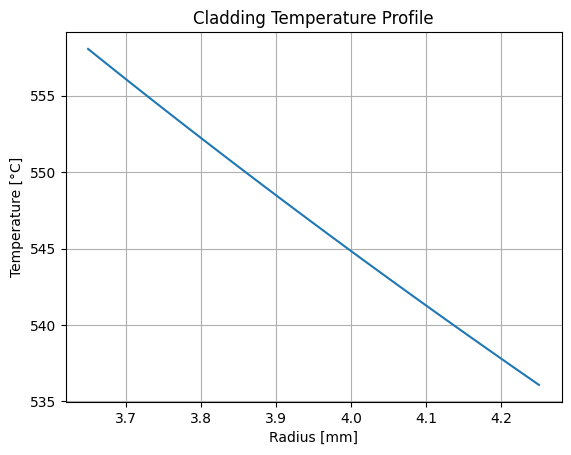

In [94]:
# Cladding temperature profile at midplane
# Assumption that the heat flux per area relative to a region (cladding, gap, fuel) is constant in that region, taking the value in the outer radius.

# Geometry of cladding
r_clad_out = D_clad_ext/2 #[mm] External radius of cladding
r_clad_in = r_clad_out - t_clad #[mm] Internal radius of cladding

# Outer cladding temperature
T_co_avg0 = (T_co_in + T_co_out) / 2 #[°C] Average temperature of coolant along the channel
T_clad_out = (q_l0 * 1e6 / P_w) / h_co + T_co_avg0 #[°C] Outer cladding temperature
print('Outer cladding temperature:', T_clad_out, '[°C]')

# Define radial temperature gradient dT/dr (r-dependent)
def dTdr_clad(r_clad, q_l0, r_clad_out, P_w, k_clad):
    return -(q_l0 * 1e3 * r_clad_out) / (P_w * k_clad * r_clad) #[°C/mm] dT/dr of cladding as a function of r

# Define temperature profile across cladding based on integration
def T_clad(r_clad, T_clad_out, q_l0, r_clad_out, P_w, k_clad):
    C = T_clad_out + (q_l0 * 1e3 * r_clad_out) / (P_w * k_clad) * np.log(r_clad_out)
    return -(q_l0 * 1e3 * r_clad_out) / (P_w * k_clad) * np.log(r_clad) + C

# Define the range of r values
r_clad_values = np.linspace(r_clad_in, r_clad_out, 100)  #values along cladding thickness

# Calculate the temperature profile
T_clad_values = T_clad(r_clad_values, T_clad_out, q_l0, r_clad_out, P_w, k_clad)

# Inner cladding temperature
T_clad_in = T_clad(r_clad_in, T_clad_out, q_l0, r_clad_out, P_w, k_clad)
print('Inner cladding temperature:', T_clad_in, '[°C]')

# Plot the results
plt.plot(r_clad_values, T_clad_values)
plt.title('Cladding Temperature Profile')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.grid()
plt.show()

Outer temperature of the gap at cladding side: 558.0504952168428 [°C]
Inner temperature of the gap at fuel side: 1075.84 °C


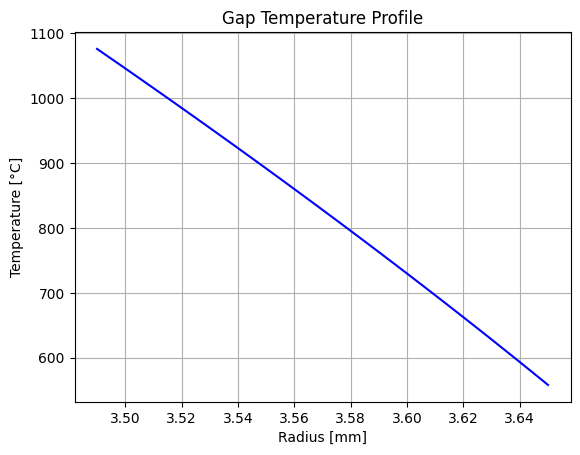

In [95]:
# Gap temperature profile at midplane

# Define constants
T_gap_out = T_clad_in #[°C] Outer temperature of the gap at cladding side
r_gap_out = r_clad_in #[mm] Outer radius of the gap
r_gap_in = D_fuel/2 #[mm] Inner radius of the gap
T_gap_out_K = T_gap_out + 273.15 #[K] Outer temperature of gap
print('Outer temperature of the gap at cladding side:',T_gap_out, '[°C]')

# Define thermal conductivity k_gap as a function of T_gap
def k_gap_func(T_gap):
    theta = (T_gap_out_K + T_gap) / 2  #[K] Average temperature in the gap
    return 15.8e-4 * theta**0.79  #[W/m-K]

# Define the ODE for the temperature profile
def dTdr_gap_func(r_gap, T_gap_K, q_l0, r_clad_out, P_w):
    k_gap = k_gap_func(T_gap_K)
    dTdr_gap = - (q_l0 * 1e3 * r_clad_out) / (P_w * k_gap * r_gap)  #[K/mm]
    return dTdr_gap

# Define the boundary condition: T_gap(r_gap_out) = T_clad_in
def T_gap_K_sol():
    # Integration range for r_gap (from r_gap_in to r_gap_out)
    r_span = [r_gap_out, r_gap_in]  # Note: integrating backwards from r_gap_out to r_gap_in
    T_initial = [T_gap_out_K]  # Initial condition: T_gap(r_gap_out) = T_clad_in in Kelvin

    # Solve the ODE
    sol = solve_ivp(dTdr_gap_func, r_span, T_initial, args=(q_l0, r_clad_out, P_w), method='RK45', t_eval=np.linspace(r_gap_out, r_gap_in, 100))

    # Convert temperature from Kelvin to Celsius
    T_gap_C_values = sol.y[0] - 273.15
    return sol.t, T_gap_C_values

# Solve the temperature profile
r_gap_values, T_gap_C_values = T_gap_K_sol()

# Print inner gap temperature
T_gap_in = T_gap_C_values[-1]  #[°C] The last value corresponds to T_gap at r_gap_in
print(f"Inner temperature of the gap at fuel side: {T_gap_in:.2f} °C")

# Plot the results
plt.plot(r_gap_values, T_gap_C_values, color='blue')
plt.title('Gap Temperature Profile')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.grid()
plt.show()

Temperature of fuel at surface: 1075.8414407325895 [°C]
Average thermal conductivity of fuel: 2.049999999999997 [W/m-°C]
Maximum temperature: 2086.2812379721117 [°C]


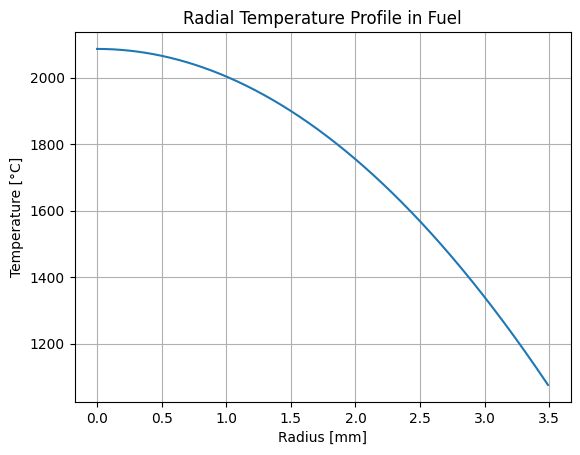

In [96]:
# Radial temperature profile at midplane of Fuel

# Define constants
T_fuel_out = T_gap_in #[°C] Outer temperature of the gap at cladding side
r_fuel_out = D_fuel/2 #[mm] Fuel radius
print('Temperature of fuel at surface:',T_fuel_out, '[°C]')

# Rough estimation of conductivity from graph
T_fuel_2 = 2200 #[°C]
int_k_fuel_2 = 63.8 #[W/cm]
T_fuel_1 = 2000 #[°C]
int_k_fuel_1 = 59.7 #[W/cm]
k_fuel_avg = (int_k_fuel_2 - int_k_fuel_1) / (T_fuel_2 - T_fuel_1) * 100 #[W/m-°C] Average thermal conductivity of fuel
print('Average thermal conductivity of fuel:',k_fuel_avg, '[W/m-°C]')

# Define C1
C1 = (q_l0 * 1e3 )/ (4 * np.pi * k_fuel_avg) #[°C]

# Define the temperature profile function
def T_fuel(r_fuel):
    F_v = (1-(r_fuel/r_fuel_out)**2)
    return T_fuel_out + C1 * F_v

# Define the range of r_fuel values (from 0 to r_fuel_ext, in mm)
r_fuel_values = np.linspace(0, r_fuel_out, 1000)  # r_fuel is in mm

# Calculate the temperature profile
T_fuel_values = T_fuel(r_fuel_values)

# Calculate the maximum temperature
print('Maximum temperature:', T_fuel(0) , '[°C]')

# Plot the results
plt.plot(r_fuel_values, T_fuel_values)  # r_fuel is already in mm
plt.title('Radial Temperature Profile in Fuel')
plt.xlabel('Radius [mm]')
plt.ylabel('Temperature [°C]')
plt.grid()
plt.show()

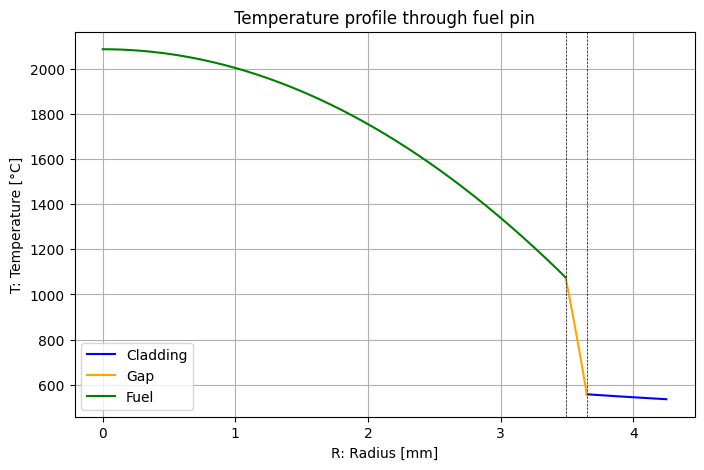

In [97]:
# Temperature profile plot

# Plotting multiple graphs
plt.figure(figsize=(8, 5))   # Set the figure size
plt.plot(r_clad_values, T_clad_values, label = 'Cladding', color = 'blue')
plt.plot(r_gap_values, T_gap_C_values, label = 'Gap', color = 'orange')
plt.plot(r_fuel_values, T_fuel_values, label = 'Fuel', color = 'green')
plt.title('Temperature profile through fuel pin')
plt.xlabel('R: Radius [mm]')
plt.ylabel('T: Temperature [°C]')
plt.axvline(r_clad_in, color='black',linewidth=0.5, ls='--')
plt.axvline(r_fuel_out, color='black',linewidth=0.5, ls='--')
plt.grid()
plt.legend()
plt.show()


Maximum temperature at external wall of cladding: 544.0755387563142 [°C]  at H = 177.1926469574556 [mm]
Maximum temperature at internal wall of cladding: 564.6431683685104 [°C]  at H = 146.74250270178018 [mm]


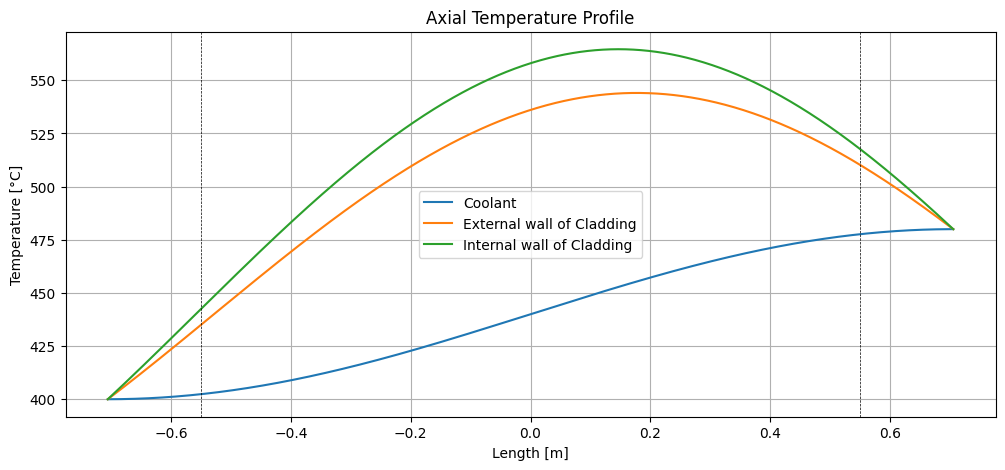

In [108]:
# Axial profile of outer wall cladding and coolant

# Define T_co_z
def T_co_z(z):
    C = T_co_in - q_l0 * 1e3 * np.sin(- np.pi * H_ext / (2 * H_ext)) * H_ext / (m_co * cp_co * np.pi)
    return q_l0 * 1e3 * np.sin(np.pi * z / H_ext) * H_ext / (m_co * cp_co * np.pi) + C

# Define T_clad_out_z
def dT_clad_coolant_z(z):
    return q_l0*1e6 * np.cos(np.pi * z / H_ext) / (P_w * h_co)

# Define T_clad_in_z
def dT_clad_z(z):
    return -q_l0*1e3 * np.cos(np.pi * z / H_ext) * np.log(r_clad_out/r_clad_in)  / (2*np.pi * k_clad)

# Define the range of z_clad values
z_values = np.linspace(-H_ext/2, H_ext/2, 1000)  # z_clad is in [m]

# Calculate the temperature profile
T_co_out_values = T_co_z(z_values)
T_clad_out_values = dT_clad_coolant_z(z_values) + T_co_z(z_values)
T_clad_in_values = T_clad_out_values - dT_clad_z(z_values)

# Calculate the maximum temperature
T_clad_out_res = minimize_scalar(lambda z: - (dT_clad_coolant_z(z) + T_co_z(z)), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_out_max = dT_clad_coolant_z(T_clad_out_res.x) + T_co_z(T_clad_out_res.x)
T_clad_in_res = minimize_scalar(lambda z: - (dT_clad_coolant_z(z) + T_co_z(z)  - dT_clad_z(z)), bounds=(-H_ext/2, H_ext/2), method='bounded')
T_clad_in_max = dT_clad_coolant_z(T_clad_in_res.x) + T_co_z(T_clad_in_res.x) - dT_clad_z(T_clad_in_res.x)
print("Maximum temperature at external wall of cladding:", T_clad_out_max, '[°C]', " at H =", T_clad_out_res.x*1000, "[mm]")
print("Maximum temperature at internal wall of cladding:", T_clad_in_max, '[°C]', " at H =", T_clad_in_res.x*1000, "[mm]")


# Plot the results
plt.figure(figsize=(12, 5))   # Set the figure size
plt.plot(z_values, T_co_out_values, label = 'Coolant')  # r_fuel is already in mm
plt.plot(z_values, T_clad_out_values, label = 'External wall of Cladding')  # r_fuel is already in mm
plt.plot(z_values, T_clad_in_values, label = 'Internal wall of Cladding')  # r_fuel is already in mm
plt.title('Axial Temperature Profile')
plt.xlabel('Length [m]')
plt.ylabel('Temperature [°C]')
plt.axvline(-H_act/2/1000, color='black',linewidth=0.5, ls='--')
plt.axvline(H_act/2/1000, color='black',linewidth=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# HOT GEOMETRY ANALYSIS

# Radial temperature profile in fuel pin

theta_gas = (T_gas_fuel + T_gas_clad)/2 #[°C] Average temperature of Helium
k_gas = 15.8e-4*theta_gas**0.79 #[W/m-K] Thermal conductivity of Helium

# Verification of values

Q_clad_out = q_l0*H_act/1000

print('Total energy in outer radius of cladding:',Q_clad_out, [kW])